## UJIAN AKHIR SEMESTER
## PEMBELAJARAN MESIN
### LUNG IMAGE SEGMENTATION USING K-MEANS CLUSTERING
### Pande Nyoman Pradnya Darsana / 170709153

#### IMPORT LIBRARY 

In [1]:
import numpy as np
import heapq as hq
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches

from sklearn import cluster
from skimage import data
from skimage import filters
from skimage import feature
from skimage import io
from skimage.measure import regionprops
from skimage.morphology import label, remove_small_objects, remove_small_holes
from skimage.color import rgb2gray

#### IMPORT IMAGE DATA

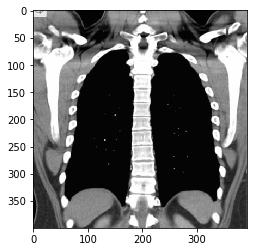

(400, 393, 3)


In [2]:
image_data = io.imread('s_Big_Lung_Normal_CT_Radiopaedia.jpg')
plt.imshow(image_data)
plt.show()
print(image_data.shape)

#### CONVERT IMAGE TO GRAYSCALE IMAGE USING RGB2GRAY

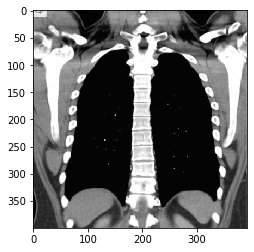

(400, 393)


In [3]:
grayscale_image = rgb2gray(image_data)
plt.imshow(grayscale_image, cmap='gray')
plt.show()
print(grayscale_image.shape)

#### K-MEANS CLUSTERING

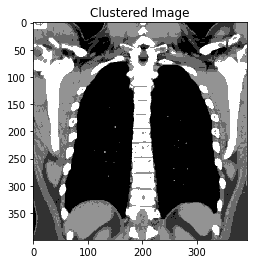

In [15]:
#convert grayscale_image to 2 dimensional array
image_2D = grayscale_image.reshape(grayscale_image.shape[0]*grayscale_image.shape[1], 1)

#Using K-Means Clustering with 5 clusters
kmeans = cluster.KMeans(n_clusters=5, random_state=0).fit(image_2D)
clustered = kmeans.cluster_centers_[kmeans.labels_]

#Reshape back to the original dimension of grayscale_image
clustered_image = clustered.reshape(grayscale_image.shape[0], grayscale_image.shape[1])
plt.imshow(clustered_image, cmap='gray')
plt.title('Clustered Image')
plt.show()

#### GET LUNG CLUSTER IMAGE FROM K-MEANS CLUSTERING RESULT

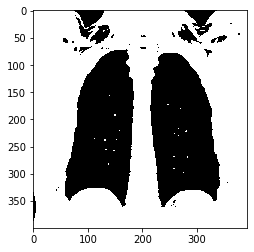

In [5]:
# Get lung image cluster by K-Means Label
# this is not recommended way to separate the lungs from the whole image

clusters_result = np.copy(clustered)
index = np.where(kmeans.labels_ != 1)
clusters_result[index] = 1
lung_image_example = clusters_result.reshape(grayscale_image.shape[0], grayscale_image.shape[1])
plt.imshow(lung_image_example, cmap='gray')
plt.show()

In [6]:
def find_darkest_cluster(clusters):
    """
    Find the darkest value in one image clusters
    function(a) -> float
    Keyword arguments:
    clusters -- the result from clustering process
    """
    darkest_cluster = 1
    for i in range(0, len(kmeans.labels_)):
        if i == 0:
            darkest_cluster = clusters[i]
        else:
            if clusters[i] < darkest_cluster:
                darkest_cluster = clusters[i]
    return darkest_cluster

def find_lung_cluster(clusters, darkest_cluster):
    """
    Find the lung by darkest cluster value in one image clusters
    function(a, b) -> list
    Keyword arguments:
    clusters -- the result from clustering process
    darkest_cluster -- the darkest value in one image clusters
    """
    lung_cluster = np.array([])
    for i in range(0, len(clusters)):
        if clusters[i] == darkest_cluster:
            lung_cluster = np.append(lung_cluster, clusters[i])
        else:
            lung_cluster = np.append(lung_cluster, 1)
    return lung_cluster

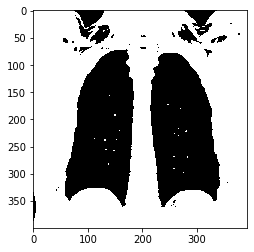

In [7]:
#get the lung cluster
lung_cluster = find_lung_cluster(clustered, find_darkest_cluster(clustered))

#reshape array from clusters result to the original grayscale image
lung_image = lung_cluster.reshape(grayscale_image.shape[0], grayscale_image.shape[1])

plt.imshow(lung_image, cmap='gray')
plt.show()

#### EDGE DETECTION USING CANNY EDGE ALGORITHM

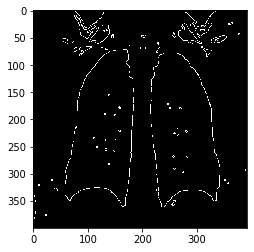

In [8]:
lung_canny_edges = feature.canny(image=lung_image)
plt.imshow(lung_canny_edges, cmap='gray')
plt.show()

#### EDGE DETECTION USING SOBEL ALGORITHM

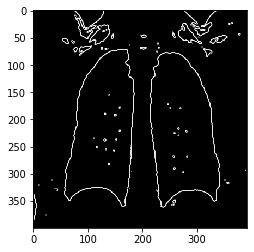

In [9]:
lung_sobel_filter = filters.sobel(image=lung_image)
plt.imshow(lung_sobel_filter, cmap='gray')
plt.show()

#### CREATE REGIONS USING REGIONPROPS FOR ANY OBJECT IN IMAGE

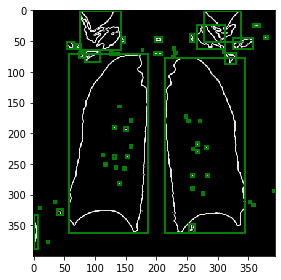

In [10]:
class ImageObject():
    def __init__(self, minr, maxr, minc, maxc):
        self.minr = minr
        self.maxr = maxr
        self.minc = minc
        self.maxc = maxc
        delta_r = maxr-minr
        delta_c = maxc-minc
        self.area = delta_r*delta_c

fig, axes = plt.subplots(1, 1)
ax = plt.gca()

label_image = label(lung_sobel_filter.astype(bool))
all_object = []
# print(label_image)

ax.imshow(lung_sobel_filter, cmap='gray')

for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    all_object.append(ImageObject(minr, maxr, minc, maxc))
    rect = mpatches.Rectangle((minc, minr),
                            maxc - minc,
                            maxr - minr,
                            fill=False,
                            edgecolor='green',
                            linewidth=2)
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

#### EXTRACT ONLY LUNG REGIONS

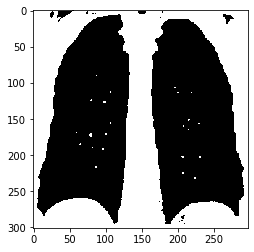

In [11]:
all_object_area = [i.area for i in all_object]
index = list(map(all_object_area.index, hq.nlargest(2, all_object_area)))

lung_image_cropped = lung_image[
    all_object[index[0]].minr-5:all_object[index[0]].maxr+5, 
    all_object[index[0]].minc-5:all_object[index[1]].maxc+5
]

plt.imshow(lung_image_cropped, cmap='gray')
plt.show()

#### CLEANING THE LUNG IMAGE SEGMENTATION RESULT

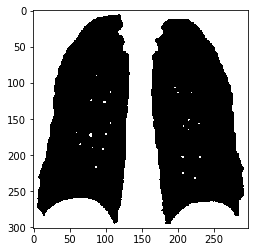

In [18]:
# lung_image_cleaned = remove_small_objects(lung_image_cropped.astype(int), 60)
lung_image_cleaned = remove_small_holes(lung_image_cropped.astype(int), 200)
plt.imshow(lung_image_cleaned.astype(int), cmap='gray')
plt.show()